## Useful imports

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.preprocessing import data_diabetes, preprocessing

## Charging the csv in a dataframe

First step is to take a look at the data to know what we are dealing with.

We charge the csv in a panda dataframe and apply multiple methods to visualize the data.

A quick search to the source of the data (https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv) gives us the information on the meaning of the data and precisions on the features.

In [ ]:
df = pd.read_csv(data_diabetes)
df

253680 different patients and 22 features.

Most of the features are binary : 1.0 if true and 0.0 if false.

Couple exemples : 
- **"Diabetes_binary** : if the patient has diabetes.
- **"Fruits"** : if the patient eats at least one fruit a day.
- **"PhysHlth"** : if the patient practiced a physical activity in the last 30 days.
- **"Smoker"** : if the patient had more than 100 cigarettes (5 packs) in his life
- **"HighBP"** : high blood pressure

**"Sex"** is 0.0 for female and 1.0 for male

Some features have numerical values :
- **"BMI"** : Body Mass Index : weight(kg) / height(m)t^2 (18.5 to 24.9 is "normal", 25 to 29.9 is "overweight")
- **"MentHlth"** : Days of poor mental health on a 1 to 30 days scale
- **"Age"** : Using the 13-level age category -> 1 = 18-24 | 9 = 60-64 | 13 = 80 
- **"Education"** : level of studies -> 0 = never attended school or only kindergarden etc...
- **"Income"** : level of income on a 1 to 8 scale (in dollars) -> 1 = less than 10,000 | 5 = less than 35,000 | 8 = 75,000 or more

In [ ]:
df.info()

In [ ]:
df.describe()

For binary features, the mean acts as a computation of the percentage of the patients which validate it.

A quick look at the means of the different binary features shows for exemple that most of the patients had a cholesterol check in the last 5 years (0.96), that around half of them smoke (0.44) and that around 14% of them has diabetes (0.139)

For the age, the education or the income we can plot an histogram showing how the data is distributed :

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["Age"], bins=20, color="skyblue", edgecolor="black")
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")

axes[1].hist(df["Education"], bins=10, color="lightgreen", edgecolor="black")
axes[1].set_title("Education Level")
axes[1].set_xlabel("Education")

axes[2].hist(df["Income"], bins=20, color="salmon", edgecolor="black")
axes[2].set_title("Income Distribution")
axes[2].set_xlabel("Income")

plt.tight_layout()
plt.show()

It shows the patient are mostly educated, have mostly high incomes and are mostly middle aged (40 to 70).

We can print exactly the number of patient having diabetes :

In [ ]:
df["Diabetes_binary"].value_counts()

It is interersting to see the correlation between features. Here we choose features that seems more relevant than others to determine if a patient has diabetes to keep the correlation matrix readable.

In [ ]:
relevant_features = ["HighBP", "HighChol", "BMI", "Sex", "Diabetes_binary"]
corr = df[relevant_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

We can see the distribution of each feature on diabetics and no diabetics

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()
for idx, feature in enumerate(df.columns[1:]):
    sns.kdeplot(
        data=df, x=feature, hue="Diabetes_binary", ax=axes[idx], fill=True, palette="Set2", alpha=0.3, common_norm=False
    )
    axes[idx].grid(True)
plt.tight_layout()
plt.show()

# K nearest neighbour


The first algorithm we decide to use is the KNN algorithm as it is easy and quick to implement. 

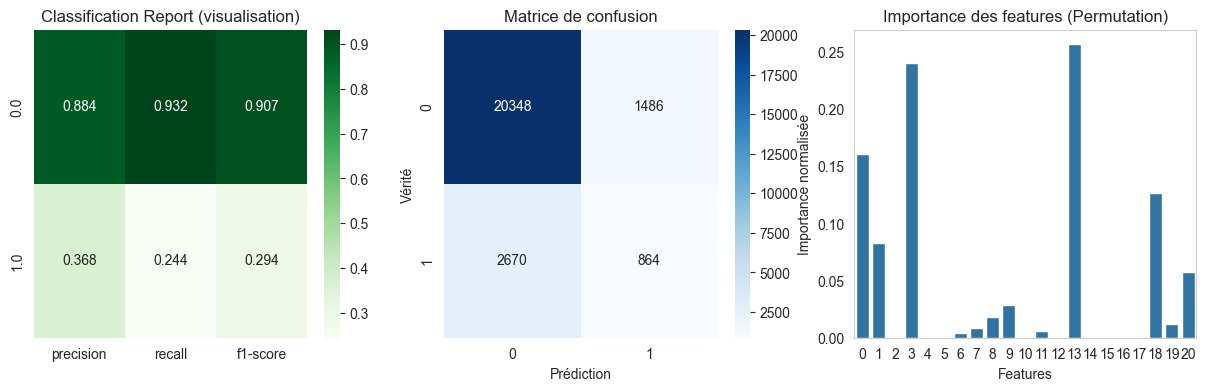

In [5]:
from src.knn import KNNModel

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_validation, y=samples.y_validation)

We have the best results for K = 3.     
At first sight, the results seem very good : for the non-diabetic people the precision is 88% and recall is 93%. 
However we see there is a problem when considering the diabic people : the precision is 37% and recall is 24%.  
The diabete dataset is more complex than the spam dataset : we need a more complex algorithm than KNN. 

## Analysis


# Neural network : MLP

In [ ]:
from src.nn_interface import MLPModel

samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)
model = MLPModel(input_size=21)
model.train(samples)

epoch: 1 	training Loss: 0.983501 
Validation loss improved → new best = 0.932984
epoch: 2 	training Loss: 0.955337 
Validation loss improved → new best = 0.931482
epoch: 3 	training Loss: 0.951186 
Validation loss improved → new best = 0.930609
epoch: 4 	training Loss: 0.947668 
No improvement in validation loss (current: 0.934469, best: 0.930609) → reverting weights
epoch: 5 	training Loss: 0.945137 
Validation loss improved → new best = 0.923404
epoch: 6 	training Loss: 0.944290 
No improvement in validation loss (current: 0.924841, best: 0.923404) → reverting weights
epoch: 7 	training Loss: 0.940216 
No improvement in validation loss (current: 0.928568, best: 0.923404) → reverting weights
epoch: 8 	training Loss: 0.942241 
No improvement in validation loss (current: 0.924883, best: 0.923404) → reverting weights
epoch: 9 	training Loss: 0.939021 
No improvement in validation loss (current: 0.928272, best: 0.923404) → reverting weights
epoch: 10 	training Loss: 0.938326 
No improvem

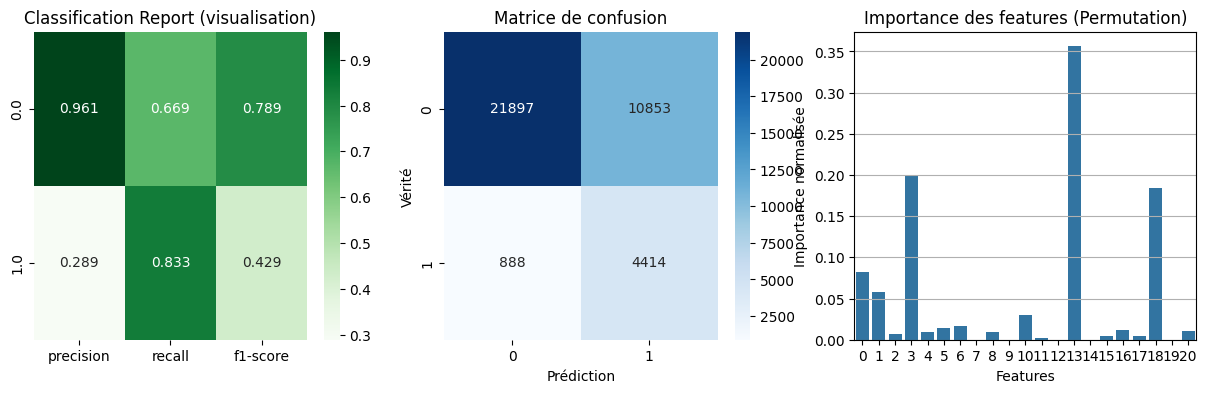

In [14]:
model.benchmark(samples.X_test, samples.y_test)

We decide to use a MLP  to tackle this complex dataset as neural networks are very powerful.  
We observe far better results than for KNN : precision for diabetic people is around 29% but recall is approx 83%. That means that the algorithm detects 83% of the diabetic cases which is a pretty good result. Indeed, eventhough the algorithm classifies non-diabetic people as diabetic people this doesn't have dramatic consequences. On the contrary, if diabetic people are classified as non-diabetic, it can have problematic oonsequences.  
That's why we prefer to have a high recall and a low precision for class 1 than a low recall and a high precision. 
Moreover the precision for diabetic people is very high (96%) and recall remains high (67%).  
We can note that some features seem to have played a bigger role than others when predicting : 13 (36% of feature importance), 3 (20%) and 18 (18%).  



# Random Forest

In [15]:
from src.RForest import RForest

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = RForest()
model.train(x=samples.X_train, y=samples.y_train)

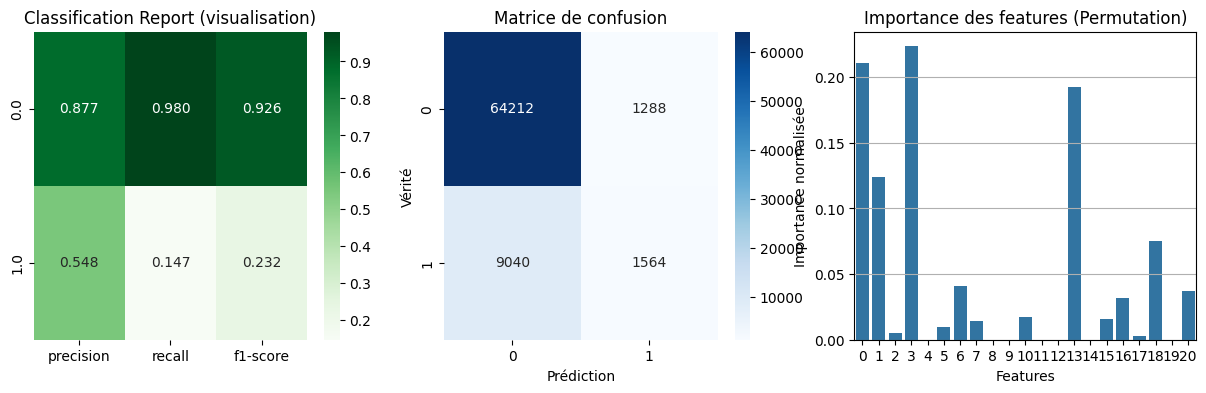

In [17]:
model.benchmark(x=samples.X_test, y=samples.y_test)

The Random Forest isn't effective at all to tackle this problem even when we optimize the hyperparameters by using a Grid Search. Recall for class 1 is around 15% which is even worse than for the KNN model...  
However an interesting thing that we can notice is that the MLP and the Random Forest use some of the same features to predict the results  : the 13th, the 18th and the 3rd one.  

# Linear SVC

In [22]:
from src.kernel_methods import LinearSVC_

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)

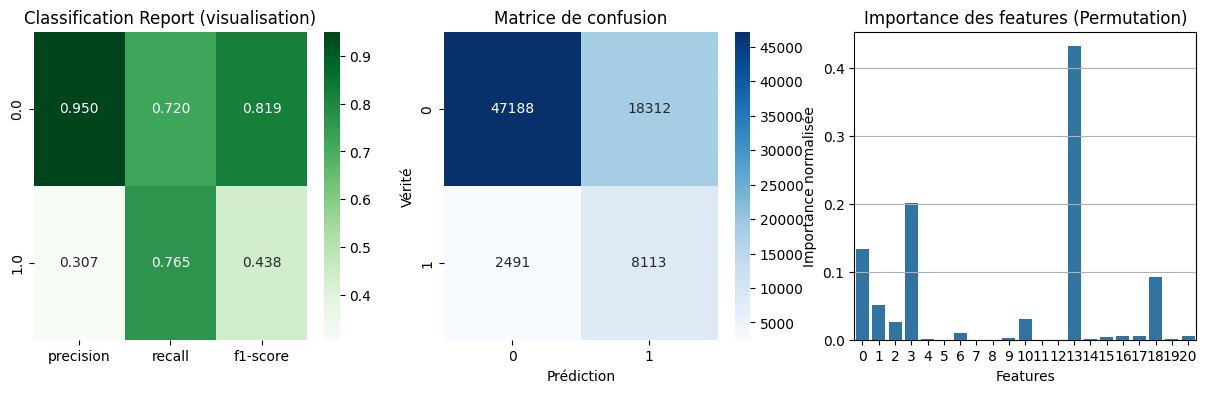

In [23]:
model.benchmark(x=samples.X_test, y=samples.y_test)

The LinearSVC model we use here is almost as good as the MLP model we used above : we have a recall of 76.5% for class 1 while still having a precision of 85% and a recall of 72% for class 0.  
We notice that this model uses less features than the others. However is has also important features in common (3,13,18) with the MLP and the KNN. 

Conclusion : 